In [28]:
import numpy as np
import matplotlib.pyplot as plt

In [8]:
# @title
import math

class PopulationNode:
    """
    Population Tensor:
    Represent a vector-valued nodecoresponingto a population of hoogeneous calar units sharing the same operation.
    - Scalars are
    treated as population of size 1 (see value.py where classical scalar-only autodiff is implemented as a base-line.).
    Objective: This abstraction is intentionally chosen to study learning dynamic, population coding, and brain-inspired models, rather than classical scalar-only autodiff.
    """
    def __init__(self, data, _parents=(), required_grad=True, op="leaf"):
        # Normalize data: always a vector
        if isinstance(data, (int, float)):
            self.data = [float(data)]
        else:
            self.data = list(data)
        self.grad = [0.0 for _ in self.data]
        self.required_grad = required_grad
        self.op = op
        self._parents = tuple(_parents)
        self._backward = lambda: None

    def __repr__(self):
        return (
            f"PopulationNode(data={self.data}, "
            f"grad={self.grad}, op='{self.op}')"
            )
    #-------------------------
    # Internal utilities
    #-------------------------

    def _enforce_shape(self, other):
        if len(self.data) != len(other.data):
            raise ValueError(
                 f" Population size mismatch:{len(self.data)} vs {len(other.data)}"
                 )
    def zero_grad(self):
        self.grad= [ 0.0 for _ in range(len(self.grad))]
    #-------------------------
    # Elementwise operations
    #-------------------------

    def __add__(self, other):
        other = other if isinstance(other, PopulationNode) else PopulationNode(other)
        self._enforce_shape(other)

        #Forward Pass
        out_data = [a + b for a, b in zip(self.data, other.data)]
        out =  PopulationNode(out_data, (self, other), op = "+")

        # --- Backward Pass ---
        def _backward():
            for i in range(len(self.data)):
                self.grad[i] += out.grad[i]
                other.grad[i] += out.grad[i]

        out._backward = _backward
        return out

    __radd__ = __add__

    def __mul__(self, other):
        # --- Forward Pass ---
        other = other if isinstance(other, PopulationNode) else PopulationNode(other)
        self._enforce_shape(other)
        # z = x * y
        out_data = [a * b for a, b in zip(self.data, other.data)]
        out = PopulationNode(out_data, (self, other), op="*")

        # --- Backward Pass ---
        def _backward():
            # For each i: z_i = x_i * y_i # dz_i/dx_i = y_i, dz_i/dy_i = x_i
            for i in range(len(self.data)):
                self.grad[i] += other.data[i] * out.grad[i]
                other.grad[i] += self.data[i] * out.grad[i]

        out._backward = _backward
        return out

    __rmul__ = __mul__

    def tanh(self):
        # --- Forward Pass ---
        out_tanh = [math.tanh(x) for x in self.data]
        out = PopulationNode(out_tanh, (self, ), op = "tanh")

        # --- Backward Pass ---
        def _backward():
            for i in range(len(self.data)):
                self.grad[i] += (1 - out_tanh[i]**2) * out.grad[i]

        out._backward= _backward
        return out

    #-------------------------
    # Reduction
    #-------------------------
    def sum(self):
        out = PopulationNode(sum(self.data), (self, ), op = "sum")
        def _backward():
            for i in range(len(self.data)):
                self.grad[i] += out.grad[0]

        out._backward= _backward
        return out

    #-------------------------
    # Reduction
    #-------------------------

    def backprop(self):
        # Performs reverse-mode autodiff.
        # --- Build topological order ---
        topo_nodes = []
        visited = set()

        def visit(v):
            if v not in visited:
                visited.add(v)
                for child in v._parents:
                    visit(child)
                topo_nodes.append(v)

        visit(self)

        # --- Seed gradient (population of size 1) ---
        # d(output)/d(output) = 1
        self.grad = [1.0 for _ in self.grad]

        # --- Backward Pass ---
        # Walk graph in reverse topological order
        for node in reversed(topo_nodes):
            node._backward()  # apply local derivative

            # Debug print (optional)
            print(
                f"[NODE] op={node.op}, value={node.data}, grad={node.grad}"
            )

**Experiment 1:** Gradient Shape Through Nonlinearity (Core learning-signal intuition)

[NODE] op=sum, value=[0.0], grad=[1.0]
[NODE] op=tanh, value=[-0.9640275800758169, -0.7615941559557649, -0.46211715726000974, 0.0, 0.46211715726000974, 0.7615941559557649, 0.9640275800758169], grad=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
[NODE] op=leaf, value=[-2.0, -1.0, -0.5, 0, 0.5, 1.0, 2.0], grad=[0.07065082485316443, 0.41997434161402614, 0.7864477329659274, 1.0, 0.7864477329659274, 0.41997434161402614, 0.07065082485316443]


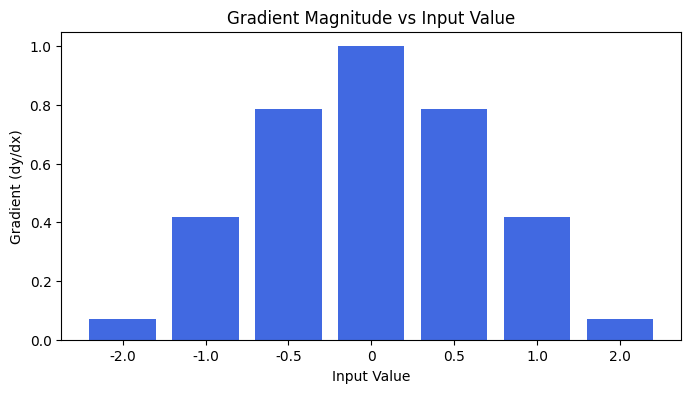

In [30]:

xs = [-2.0, -1.0, -0.5, 0, 0.5, 1.0, 2.0]
x = PopulationNode(xs)
y = x.tanh()
y.sum().backprop()

plt.figure(figsize=(8,4))
plt.bar(range(len(xs)), x.grad, color='royalblue')
plt.xticks(range(len(xs)), xs)
plt.title("Gradient Magnitude vs Input Value")
plt.xlabel("Input Value")
plt.ylabel("Gradient (dy/dx)")
plt.savefig("exp1_gradient_shape.png", dpi=300, bbox_inches="tight")
plt.show()


**Observation**
- **Large gradients**: Inputs near 0, where tanh is steep and responsive.

- **Vanishing gradients**: Inputs far from 0, where tanh saturates and its derivative approaches 0.

- **Symmetry**: Large positive or negative values both produce small gradients (slow learning), while small values of either sign produce large gradients (fast learning).

**Experiment 2:**  Depth-Induced Gradient Decay (Vanishing gradient mechanism)

In [55]:
def depth_gradients(val, depth=8):
    """Return gradient at each layer depth for a given input value."""
    x = PopulationNode(val)
    layers = [x]

    # Forward pass through repeated tanh layers
    for _ in range(depth):
        layers.append(layers[-1].tanh())
    # Backprop from final layer
    layers[-1].backprop()
    # Extract gradient at each layer
    return [layer.grad[0] for layer in layers]


[NODE] op=tanh, value=[0.3258166487960561], grad=[1.0]
[NODE] op=tanh, value=[0.33814088946538085], grad=[0.8938435113673074]
[NODE] op=tanh, value=[0.3519919121889121], grad=[0.7916421047131201]
[NODE] op=tanh, value=[0.367715548505944], grad=[0.6935589887858239]
[NODE] op=tanh, value=[0.3857788849071793], grad=[0.599779601114259]
[NODE] op=tanh, value=[0.40683132335207434], grad=[0.510517193231001]
[NODE] op=tanh, value=[0.4318081805950961], grad=[0.42602061160003407]
[NODE] op=tanh, value=[0.46211715726000974], grad=[0.34658553053894303]
[NODE] op=leaf, value=[0.5], grad=[0.27257140477114494]
[NODE] op=tanh, value=[0.41346084639570524], grad=[1.0]
[NODE] op=tanh, value=[0.43977852653283755], grad=[0.8290501284977471]
[NODE] op=tanh, value=[0.47195619292203916], grad=[0.6687075620489034]
[NODE] op=tanh, value=[0.5125841451937511], grad=[0.5197578689154532]
[NODE] op=tanh, value=[0.5662285757646345], grad=[0.38319538397327985]
[NODE] op=tanh, value=[0.6419540521719098], grad=[0.260337

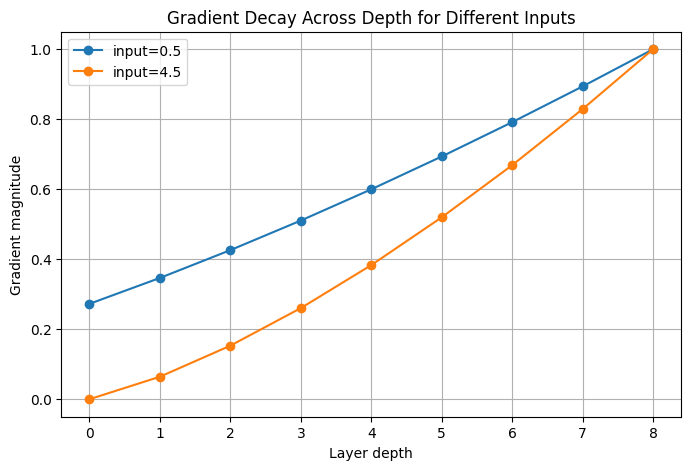

In [38]:
# @title
# Inputs to test
vals = [0.5, 4.5]
depth = 8

plt.figure(figsize=(8, 5))

for v in vals:
    grads = depth_gradients(v, depth)
    plt.plot(range(depth + 1), grads, marker='o', label=f"input={v}")

plt.title("Gradient Decay Across Depth for Different Inputs")
plt.xlabel("Layer depth")
plt.ylabel("Gradient magnitude")
plt.grid(True)
plt.legend()

plt.savefig("exp2_depth_gradient_decay.png", dpi=300, bbox_inches="tight")
plt.show()


### **Observation**: Pay attention to the gradients
- For input = 0.5: Not saturated, Gradients decay slowly and learning signal survives deeper

- For input = 4.5: Deep in saturatation, Gradients collapse almost instantly and learning signal dies earlier.
  - **Gradients shrink** with depth because each layer multiplies its local derivative into the chain.

  - **Saturated tanh inputs (very negative or very positive)** have derivatives near 0, so multiplying many of these across layers causes the gradient to decay rapidly.

**Experiment 3**: Population vs Scalar Sensitivity (Why population abstraction matters)

In [43]:
# --- Compute gradients ---
x_scalar = PopulationNode(0.5)
y_scalar = x_scalar.tanh()
y_scalar.backprop()
scalar_grad_sum = sum(x_scalar.grad)
print("Scalar gradient sum= ",scalar_grad_sum)
print()

x_pop = PopulationNode([0.5, 0.5, 0.5, 0.5])
y_pop = x_pop.tanh()
y_pop.sum().backprop()
population_grad_sum = sum(x_pop.grad)
print("Population gradient sum= ", population_grad_sum)
# --- Visualization ---
labels = ["Scalar (1 unit)", "Population (4 units)"]
values = [scalar_grad_sum, population_grad_sum]

[NODE] op=tanh, value=[0.46211715726000974], grad=[1.0]
[NODE] op=leaf, value=[0.5], grad=[0.7864477329659274]
Scalar gradient sum=  0.7864477329659274

[NODE] op=sum, value=[1.848468629040039], grad=[1.0]
[NODE] op=tanh, value=[0.46211715726000974, 0.46211715726000974, 0.46211715726000974, 0.46211715726000974], grad=[1.0, 1.0, 1.0, 1.0]
[NODE] op=leaf, value=[0.5, 0.5, 0.5, 0.5], grad=[0.7864477329659274, 0.7864477329659274, 0.7864477329659274, 0.7864477329659274]
Population gradient sum=  3.1457909318637096


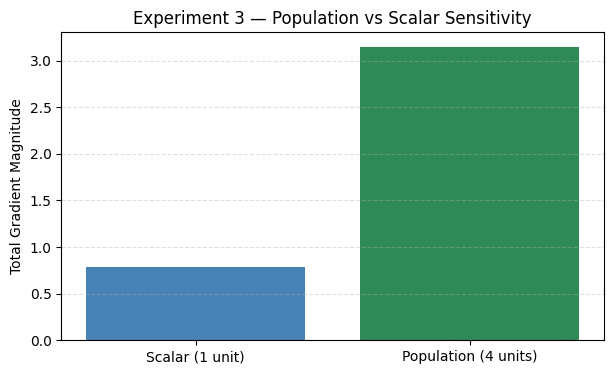

Scalar gradient sum: 0.7864477329659274
Population gradient sum: 3.1457909318637096


In [44]:
# @title
plt.figure(figsize=(7,4))
plt.bar(labels, values, color=["steelblue", "seagreen"])
plt.title("Experiment 3 — Population vs Scalar Sensitivity")
plt.ylabel("Total Gradient Magnitude")
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Save figure
plt.savefig("exp3_population_vs_scalar.png", dpi=300, bbox_inches="tight")
plt.show()

print("Scalar gradient sum:", scalar_grad_sum)
print("Population gradient sum:", population_grad_sum)


**Observation**:
  - Population coding amplifies sensitivity.
Each unit has the same local gradient, but the aggregate gradient grows with population size.

**This is a core idea in**:
- Biological neural populations
- Distributed representations
- Redundancy for robustness
- Gradient stability in wide networks


**Experiment 4**: Shared Subgraph in Population (Credit assignment)

In [46]:
x = PopulationNode([1.0, 2.0, 3.0])
y = x * x + x
z = y.sum()
z.backprop()

[NODE] op=sum, value=[20.0], grad=[1.0]
[NODE] op=+, value=[2.0, 6.0, 12.0], grad=[1.0, 1.0, 1.0]
[NODE] op=*, value=[1.0, 4.0, 9.0], grad=[1.0, 1.0, 1.0]
[NODE] op=leaf, value=[1.0, 2.0, 3.0], grad=[3.0, 5.0, 7.0]



Verify analytically
For each element:
- $\frac{\partial }{\partial x}(x^2$ + 𝑥) => 2𝑥+ 1
  - 2(1.0)+ 1 = 3
  - 2(2.0)+ 1 = 5
  - 2(3.0)+ 1 = 7


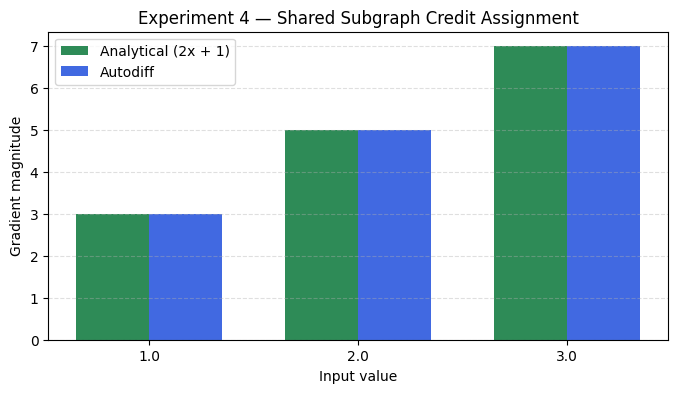

Inputs: [1. 2. 3.]
Analytical gradients: [3. 5. 7.]
Autodiff gradients: [3. 5. 7.]


In [50]:
# @title
autodiff_grads = np.array(x.grad)
inputs = np.array([1.0, 2.0, 3.0])

# --- Analytical gradients ---
analytical_grads = 2 * inputs + 1

# --- Visualization ---
plt.figure(figsize=(8,4))

bar_width = 0.35
indices = np.arange(len(inputs))

plt.bar(indices - bar_width/2, analytical_grads, width=bar_width, label="Analytical (2x + 1)", color="seagreen")
plt.bar(indices + bar_width/2, autodiff_grads, width=bar_width, label="Autodiff", color="royalblue")

plt.xticks(indices, inputs)
plt.xlabel("Input value")
plt.ylabel("Gradient magnitude")
plt.title("Experiment 4 — Shared Subgraph Credit Assignment")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Save figure
plt.savefig("exp4_credit_assignment.png", dpi=300, bbox_inches="tight")
plt.show()

print("Inputs:", inputs)
print("Analytical gradients:", analytical_grads)
print("Autodiff gradients:", autodiff_grads)


### Observation:
-  Autodiff engine computes credit assignment in a population setting, even when a node is used multiple time in the computation graph. Each element of the population gets the correct accumulated gradients from all paths.ted gradient from all paths.

## Experiment 5 — Reduction as Information Bottleneck(Learning signal compression)

In [52]:
# --- Case 1: all units responsive ---
x1 = PopulationNode([1.0, 1.0, 1.0])
y1 = x1.tanh()
y1.sum().backprop()
grads1 = np.array(x1.grad)

# --- Case 2: one saturated unit ---
x2 = PopulationNode([1.0, 1.0, 3.0])
y2 = x2.tanh()
y2.sum().backprop()
grads2 = np.array(x2.grad)

[NODE] op=sum, value=[2.2847824678672946], grad=[1.0]
[NODE] op=tanh, value=[0.7615941559557649, 0.7615941559557649, 0.7615941559557649], grad=[1.0, 1.0, 1.0]
[NODE] op=leaf, value=[1.0, 1.0, 1.0], grad=[0.41997434161402614, 0.41997434161402614, 0.41997434161402614]
[NODE] op=sum, value=[2.51824306559826], grad=[1.0]
[NODE] op=tanh, value=[0.7615941559557649, 0.7615941559557649, 0.9950547536867305], grad=[1.0, 1.0, 1.0]
[NODE] op=leaf, value=[1.0, 1.0, 3.0], grad=[0.41997434161402614, 0.41997434161402614, 0.009866037165440211]


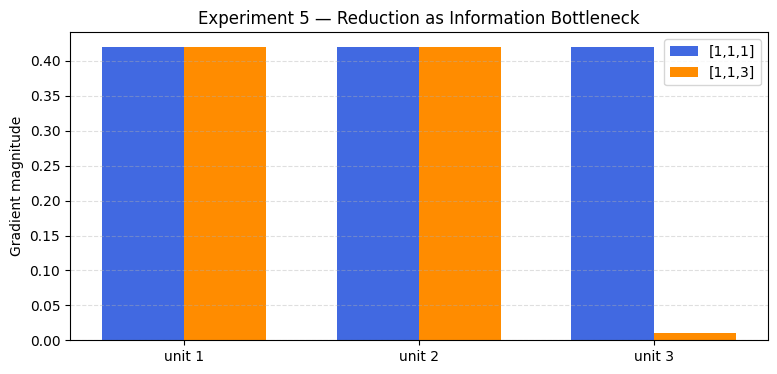

Sum of gradients (all responsive): 1.2599230248420783
Sum of gradients (one saturated): 0.8498147203934925


In [54]:
# @title
# --- Visualization ---
plt.figure(figsize=(9,4))

indices = np.arange(3)
bar_width = 0.35

plt.bar(indices - bar_width/2, grads1, width=bar_width, label="[1,1,1]", color="royalblue")
plt.bar(indices + bar_width/2, grads2, width=bar_width, label="[1,1,3]", color="darkorange")

plt.xticks(indices, ["unit 1", "unit 2", "unit 3"])
plt.ylabel("Gradient magnitude")
plt.title("Experiment 5 — Reduction as Information Bottleneck")
plt.legend()
plt.grid(axis="y", linestyle="--", alpha=0.4)

# Save figure
plt.savefig("exp5_information_bottleneck.png", dpi=300, bbox_inches="tight")
plt.show()

print("Sum of gradients (all responsive):", grads1.sum())
print("Sum of gradients (one saturated):", grads2.sum())


**Observation: Information Bottleneck**
- A reduction like sum() collapses a structured population into a single scalar.

- This forces all units to share the same upstream gradient, destroying population identity.

- When one unit is saturated (e.g., input = 3.0), its derivative is near zero, which shrinks the total gradient.

- Because the reduction compresses the learning signal, even responsive units receive a weaker gradient.

- This demonstrates how reductions act as information bottlenecks, limiting the richness of population-coded representations.

## Experiment 6: Gradient Symmetry Breaking (Why identical units diverge)

In [60]:
import matplotlib.pyplot as plt
import numpy as np

# --- Compute gradients ---
x = PopulationNode([0.5, 0.5001])
y = x.tanh()
y.sum().backprop()

inputs = np.array([0.5, 0.5001])
grads = np.array(x.grad)
diff = abs(grads[1] - grads[0])
print("Difference", diff)

[NODE] op=sum, value=[0.924312955658912], grad=[1.0]
[NODE] op=tanh, value=[0.46211715726000974, 0.46219579839890224], grad=[1.0, 1.0]
[NODE] op=leaf, value=[0.5, 0.5001], grad=[0.7864477329659274, 0.7863750439424013]
Difference 7.268902352608464e-05


[NODE] op=sum, value=[0.924312955658912], grad=[1.0]
[NODE] op=tanh, value=[0.46211715726000974, 0.46219579839890224], grad=[1.0, 1.0]
[NODE] op=leaf, value=[0.5, 0.5001], grad=[0.7864477329659274, 0.7863750439424013]


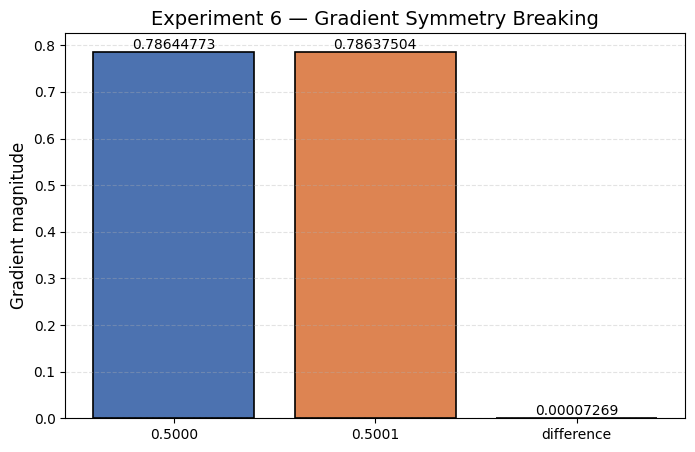

Inputs: [0.5    0.5001]
Gradients: [0.78644773 0.78637504]
Difference: 7.268902352608464e-05


In [59]:
# @title
# --- Visualization ---
plt.figure(figsize=(8,5))

labels = ["0.5000", "0.5001", "difference"]
values = [grads[0], grads[1], diff]
colors = ["#4C72B0", "#DD8452", "#55A868"]

bars = plt.bar(
    labels,
    values,
    color=colors,
    edgecolor="black",
    linewidth=1.2
)

plt.title("Experiment 6 — Gradient Symmetry Breaking", fontsize=14)
plt.ylabel("Gradient magnitude", fontsize=12)
plt.grid(axis="y", linestyle="--", alpha=0.35)

# Annotate each bar with its value
for bar, value in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width()/2,
        value + 0.00001,
        f"{value:.8f}",
        ha="center",
        va="bottom",
        fontsize=10
    )

# Save figure
plt.savefig("exp6_symmetry_breaking_with_difference.png", dpi=300, bbox_inches="tight")
plt.show()

print("Inputs:", inputs)
print("Gradients:", grads)
print("Difference:", diff)


### Observation:
- Even though the inputs differ by only **0.0001**, their gradients differ measurably.
After the reduction (sum()), both units share the same upstream error signal, but their slightly different local derivatives scale it differently.
- This tiny mismatch breaks the symmetry and seeds divergence in their learning trajectories.
- Symmetry breaking emerges naturally from deterministic gradient flow — no noise required.

## Experiment 7: Gradient Flow Without Updates (Dynamics without learning)

In [62]:
# --- Compute gradients for each input ---
inputs = np.array([-3.0, -1.0, 0.0, 1.1, 3.0])
grads = []

for v in inputs:
    x = PopulationNode(v)
    y = x.tanh()
    y.backprop()
    grads.append(x.grad[0])

[NODE] op=tanh, value=[-0.9950547536867305], grad=[1.0]
[NODE] op=leaf, value=[-3.0], grad=[0.009866037165440211]
[NODE] op=tanh, value=[-0.7615941559557649], grad=[1.0]
[NODE] op=leaf, value=[-1.0], grad=[0.41997434161402614]
[NODE] op=tanh, value=[0.0], grad=[1.0]
[NODE] op=leaf, value=[0.0], grad=[1.0]
[NODE] op=tanh, value=[0.8004990217606297], grad=[1.0]
[NODE] op=leaf, value=[1.1], grad=[0.35920131616027484]
[NODE] op=tanh, value=[0.9950547536867305], grad=[1.0]
[NODE] op=leaf, value=[3.0], grad=[0.009866037165440211]


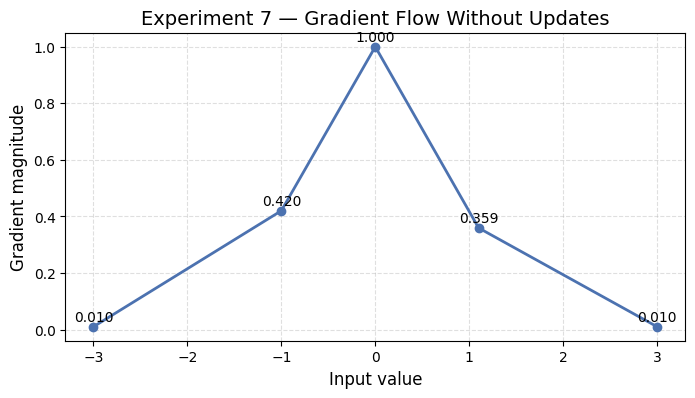

Inputs: [-3.  -1.   0.   1.1  3. ]
Gradients: [0.00986604 0.41997434 1.         0.35920132 0.00986604]


In [64]:
# @title
grads = np.array(grads)

# --- Visualization ---
plt.figure(figsize=(8,4))

plt.plot(inputs, grads, marker='o', linewidth=2, color="#4C72B0")
plt.title("Experiment 7 — Gradient Flow Without Updates", fontsize=14)
plt.xlabel("Input value", fontsize=12)
plt.ylabel("Gradient magnitude", fontsize=12)
plt.grid(True, linestyle="--", alpha=0.4)

# Annotate each point
for i, g in zip(inputs, grads):
    plt.text(i, g + 0.02, f"{g:.3f}", ha="center", fontsize=10)

# Save figure
plt.savefig("exp7_gradient_flow.png", dpi=300, bbox_inches="tight")
plt.show()

print("Inputs:", inputs)
print("Gradients:", grads)


**Observation**:
- Even without performing any parameter updates, the gradient reveals the local learning signal. Inputs near zero lie in the steep region of tanh, producing large gradients. Inputs far from zero lie in saturated regions, producing vanishing gradients.
- This experiment shows that gradients encode the potential for learning, independent of whether learning actually occurs. Gradient flow is an instrinsic property of the function, not the optimizer.

  - **Intrinsic**: Built‑in, natural, already there
  - **Gradient**: How sensitive the output is to a small change in the input
  - **Flow**: How that sensitivity behaves across different inputs